# Name: Nalet Meinen

- Please answer the question in the same order as in the assignment and use the same question numbers;
- Don't answer the questions in the code comments. Use the text cells in your notebook;
- Remove clutter such as unused code lines instead of turning them into comments;
- Make sure the right execution order of the notebook cells is from top to bottom. A TA should be able to reproduce your results by simply clicking "Run All" without having to guess which cells should be executed first.

# Assignment 1 ATML 2020
Download the dataset files from ILIAS and put them in the same folder as this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

images = np.load('data/imgs_train.npy')
labels = np.load('data/labels_train.npy')

test_images = np.load('data/imgs_test.npy')
test_labels = np.load('data/labels_test.npy')

## Task 1. Prepare data for training and model selection

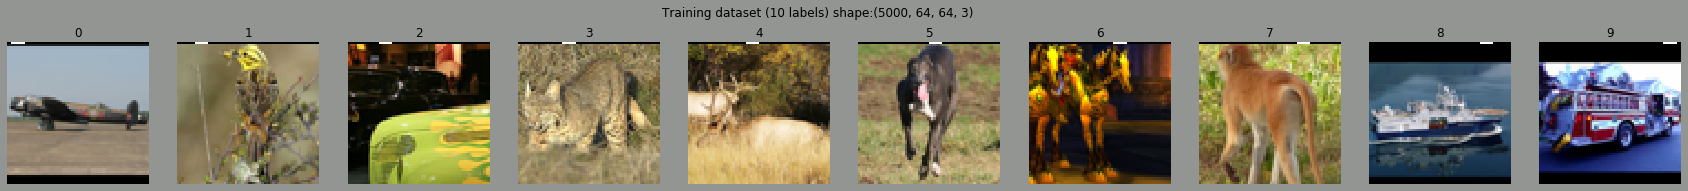

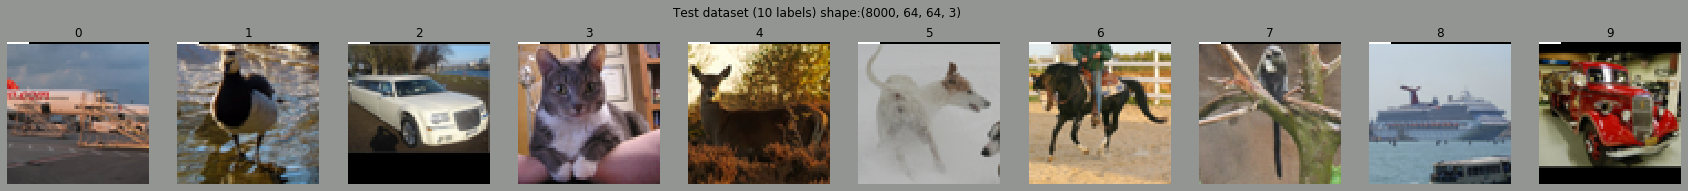

In [2]:
%matplotlib inline

def plot_image(title, images, labels, top_only=False):
    img_choices = []
    for label in np.unique(labels):
        img_choices.append(np.where(labels==label)[0][0])

    fig, axs = plt.subplots(1, 10, figsize=(30, 3))

    for ax, selected_img in zip(axs, img_choices):
        if top_only:
            ax.imshow(images[selected_img][:2,...])
        else:
            ax.imshow(images[selected_img])
            ax.axis('off')
            ax.set_title(str(labels[selected_img]))

    fig.suptitle(title + str(images.shape))
    fig.subplots_adjust(top=0.85)
    fig.patch.set_facecolor('xkcd:gray')    
    plt.show()

plot_image('Training dataset (10 labels) shape:', images, labels)
plot_image('Test dataset (10 labels) shape:', test_images, test_labels)

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose, ToPILImage
from torch.utils.data import DataLoader
class NumpyDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        datapoint = self.data[index]
        target = self.target[index]
        return datapoint, target
    
    def __len__(self):
        return len(self.data)

transforms = Compose([ToPILImage(), 
                      ToTensor(), # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                      Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5))]) # scales to [-1.0, 1.0]

transforms_reduce = Compose([ToPILImage(),
                             Resize((32,32)), 
                      ToTensor(), # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                      Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5))]) # scales to [-1.0, 1.0]

def split_data(images, labels, split_ratio=0.9):
    train_images = np.empty((0,images.shape[1], images.shape[2], images.shape[3]), images.dtype)
    train_labels = np.empty((0), labels.dtype)
    val_images = np.empty((0,images.shape[1], images.shape[2], images.shape[3]), images.dtype)
    val_labels = np.empty((0), labels.dtype)

    for label in np.unique(labels):
        selection = np.where(labels==label)[0]
        split_point = int(len(selection) * split_ratio)

        train_images = np.append(train_images, images[selection[:split_point]], axis=0)
        train_labels = np.append(train_labels, labels[selection[:split_point]], axis=0)
        val_images = np.append(val_images, images[selection[split_point:]], axis=0)
        val_labels = np.append(val_labels, labels[selection[split_point:]], axis=0)
      
    return train_images, train_labels, val_images, val_labels

def prepare_dataset(images, labels, val_images, val_labels, test_images, test_labels, reduce = False):
    images_ = []
    val_images_ = []
    test_images_ = []

    _t = transforms
    if reduce: _t = transforms_reduce

    for img in images: images_.append(_t(img))
    for img in val_images: val_images_.append(_t(img))
    for img in test_images: test_images_.append(_t(img))

    images = images_
    val_images = val_images_
    test_images = test_images_

    train_dataset = NumpyDataset(images, labels)
    batch_size = 32
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) #set num_workers = 0, to fix BrokenPipeError in Windows

    val_dataset = NumpyDataset(val_images, val_labels)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    test_dataset = NumpyDataset(test_images, test_labels)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_dataset, train_dataloader, val_dataset, val_dataloader, test_dataset, test_dataloader

In [4]:
train_images, train_labels, val_images, val_labels = split_data(images, labels) #with default ration of 0.9
train_dataset, train_dataloader, val_dataset, val_dataloader, test_dataset, test_dataloader = prepare_dataset(train_images, train_labels, val_images, val_labels, test_images, test_labels)

## Task 2. Train a linear classification model

In [1]:
import torch.nn as nn
class LinearModel(nn.Module):
    
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(input_dim, 10, bias=True) # outputs 2 values - score for cat and score for dog
        
    def forward(self, input):
        out = input.view(input.size(0), -1) # convert batch_size x 3 x imH x imW to batch_size x (3*imH*imW)
        out = self.fc(out) # Applies out = input * A + b. A, b are parameters of nn.Linear that we want to learn
        return out

def train_epoch(model, train_dataloader, optimizer, loss_fn):
    losses = []
    correct_predictions = 0
    # Iterate mini batches over training dataset
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        # Run predictions
        output = model(images)
        # Set gradients to zero
        optimizer.zero_grad()
        # Compute loss
        loss = loss_fn(output, labels)
        # Backpropagate (compute gradients)
        loss.backward()
        # Make an optimization step (update parameters)
        optimizer.step()
        # Log metrics
        losses.append(loss.item())
        predicted_labels = output.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    # Return loss values for each iteration and accuracy
    mean_loss = np.array(losses).mean()
    return mean_loss, accuracy

def evaluate(model, dataloader, loss_fn):
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Run predictions
            output = model(images)
            # Compute loss
            loss = loss_fn(output, labels)
            # Save metrics
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            losses.append(loss.item())
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(dataloader.dataset)
    # Return mean loss and accuracy
    return mean_loss, accuracy

def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_fn):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {:02d}/{:02d}: train_loss: {:.4f}, train_accuracy: {:08.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies

In [6]:
def train_linear(learning_rate,n_epochs,size=64*64*3):
    print('Run with ' + str(learning_rate) + ' learning rate and number of epochs: ' + str(n_epochs))
    model = LinearModel(size)
    model = model.to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_fn)

    return learning_rate,n_epochs, train_losses, val_losses, train_accuracies, val_accuracies, model, loss_fn

In [7]:

result_test_01_10 = train_linear(0.01,10)
result_test_001_20 = train_linear(0.001,20)
result_test_0001_30 = train_linear(0.0001,30)

Run with 0.01 learning rate and number of epochs: 10
Epoch 01/10: train_loss: 0.5647, train_accuracy: 089.3111, val_loss: 0.1348, val_accuracy: 99.8000
Epoch 02/10: train_loss: 0.0765, train_accuracy: 099.9778, val_loss: 0.0618, val_accuracy: 100.0000
Epoch 03/10: train_loss: 0.0404, train_accuracy: 100.0000, val_loss: 0.0406, val_accuracy: 100.0000
Epoch 04/10: train_loss: 0.0275, train_accuracy: 100.0000, val_loss: 0.0305, val_accuracy: 100.0000
Epoch 05/10: train_loss: 0.0209, train_accuracy: 100.0000, val_loss: 0.0242, val_accuracy: 100.0000
Epoch 06/10: train_loss: 0.0168, train_accuracy: 100.0000, val_loss: 0.0202, val_accuracy: 100.0000
Epoch 07/10: train_loss: 0.0140, train_accuracy: 100.0000, val_loss: 0.0174, val_accuracy: 100.0000
Epoch 08/10: train_loss: 0.0121, train_accuracy: 100.0000, val_loss: 0.0153, val_accuracy: 100.0000
Epoch 09/10: train_loss: 0.0106, train_accuracy: 100.0000, val_loss: 0.0136, val_accuracy: 100.0000
Epoch 10/10: train_loss: 0.0094, train_accuracy:

#### Report below:
**REPORT** *plots, validation losses and accuracies for different learning rates, learning rate for the selected best performing model*

## Task 3. Evaluate on the test set

In [8]:
def plot_results(train_results,test_dataloder,image_size=(64,64,3),previous_results=None):

    learning_rate,n_epochs, train_losses, val_losses, train_accuracies, val_accuracies, model, loss_fn = train_results

    print('Results from ' + str(learning_rate) + ' learning rate and number of epochs: ' + str(n_epochs))

    parameters_t = list(model.parameters()).copy()

    maxVal = parameters_t[0].max()
    minVal = abs(parameters_t[0].min())
    maxVal = max(maxVal,minVal)
    parameters_t[0] = parameters_t[0] / maxVal
    parameters_t[0] = parameters_t[0] / 2
    parameters_t[0] = parameters_t[0] + 0.5

    fig, axs = plt.subplots(1, 10, figsize=(30, 3))
    for ax, w_index in zip(axs, range(0,10)):
        raw_weights = parameters_t[0][w_index].cpu().detach().numpy()
        image_size_c = image_size[0]*image_size[1]
        image_weights = np.empty(image_size)
        image_weights[..., 0] = raw_weights[:image_size_c*1].reshape((image_size[0],image_size[1]))
        image_weights[..., 1] = raw_weights[image_size_c*1:image_size_c*2].reshape((image_size[0],image_size[1]))
        image_weights[..., 2] = raw_weights[image_size_c*2:image_size_c*3].reshape((image_size[0],image_size[1]))
        ax.imshow(image_weights)
        ax.axis('off')
        ax.set_title(w_index + 1)

    fig.suptitle("Weights of each layer")
    fig.subplots_adjust(top=0.85)
    fig.patch.set_facecolor('xkcd:gray')      
    plt.show()
    
    fig, axs = plt.subplots(1, 2,figsize=(15, 4))
    if previous_results != None:
        p_learning_rate,p_n_epochs, p_train_losses, p_val_losses, p_train_accuracies, p_val_accuracies, p_model, p_loss_fn = previous_results
    
    axs[0].plot(np.arange(n_epochs), train_losses)
    axs[0].plot(np.arange(n_epochs), val_losses)
    if previous_results != None:
        axs[0].plot(np.arange(p_n_epochs), p_train_losses)
        axs[0].plot(np.arange(p_n_epochs), p_val_losses)
        axs[0].legend(['train_loss', 'val_loss', 'previous train_loss', 'previous val_loss'])
    else:
        axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss value')
    axs[0].set_title('Train/val loss')

    axs[1].plot(np.arange(n_epochs), train_accuracies)
    axs[1].plot(np.arange(n_epochs), val_accuracies)
    if previous_results != None:
        axs[1].plot(np.arange(p_n_epochs), p_train_accuracies)
        axs[1].plot(np.arange(p_n_epochs), p_val_accuracies)
        axs[1].legend(['train_acc', 'val_acc','previous train_acc', 'previous val_acc'])
    else:
        axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Train/val accuracy')

    plt.show()

    m_loss, accuracy = evaluate(model, test_dataloder, loss_fn)

    print("Mean loss "+ str(m_loss) + ", Accuracy: " + str(accuracy) + "\n")



Results from 0.01 learning rate and number of epochs: 10


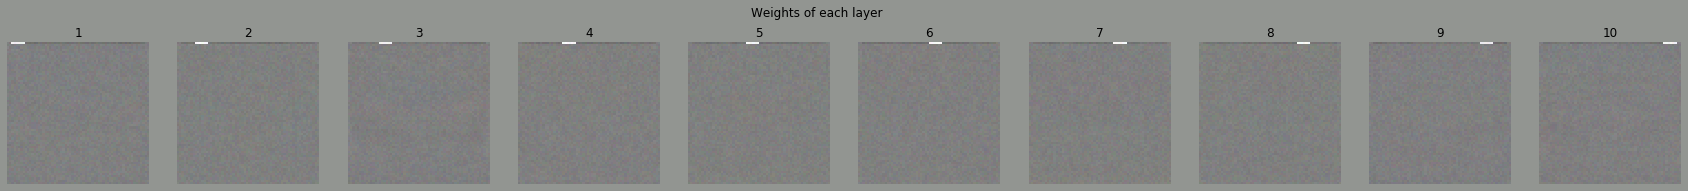

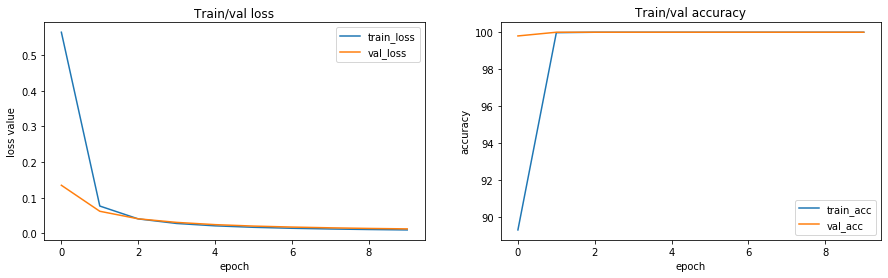

Mean loss 4.510201296806335, Accuracy: 10.0

Results from 0.001 learning rate and number of epochs: 20


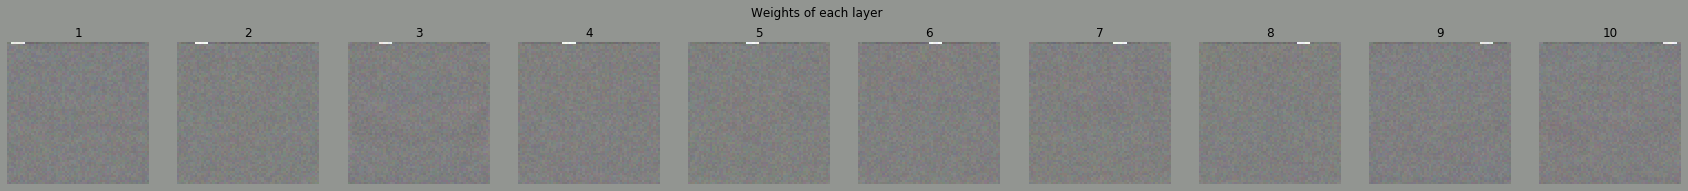

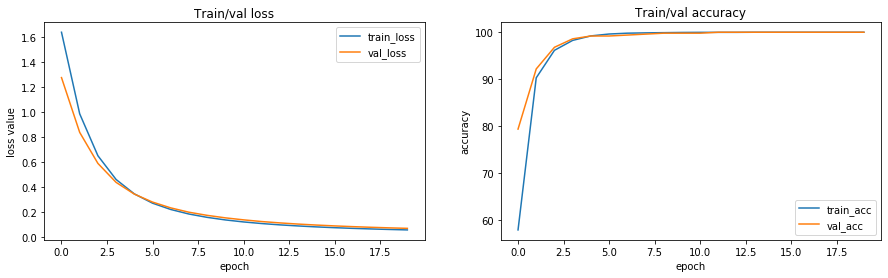

Mean loss 3.108478741645813, Accuracy: 10.1625

Results from 0.0001 learning rate and number of epochs: 30


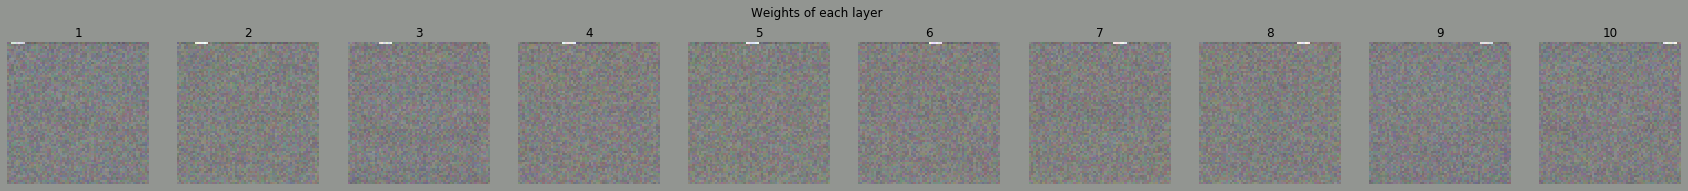

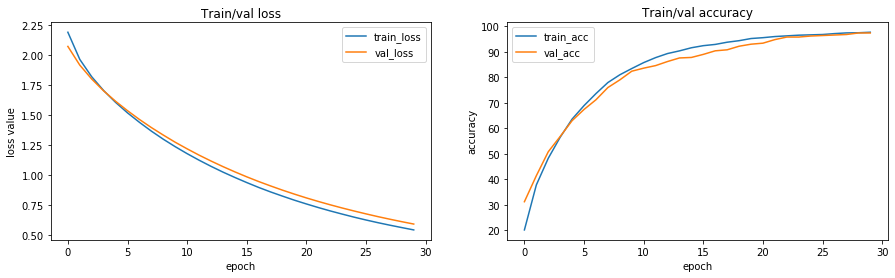

Mean loss 1.9905174655914306, Accuracy: 24.0625



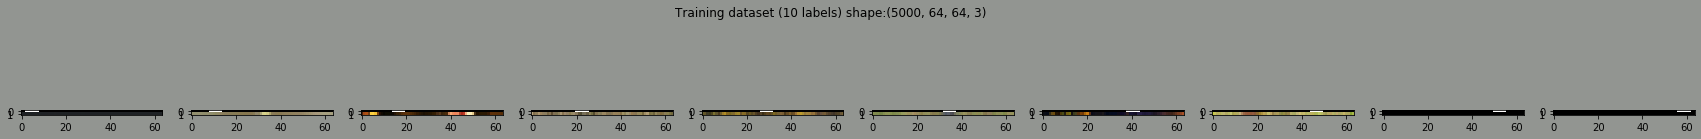

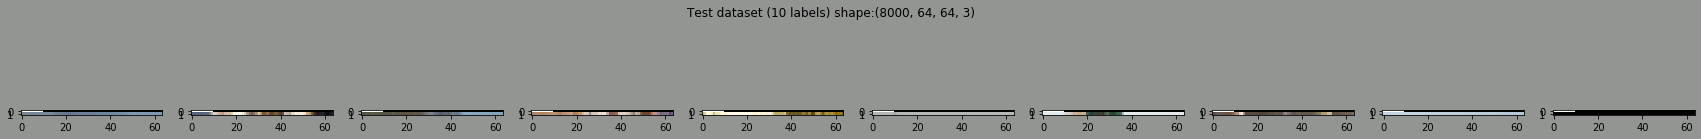

In [9]:
plot_results(result_test_01_10, test_dataloader)
plot_results(result_test_001_20, test_dataloader)
plot_results(result_test_0001_30, test_dataloader)

plot_image('Training dataset (10 labels) shape:', images, labels, top_only=True)
plot_image('Test dataset (10 labels) shape:', test_images, test_labels, top_only=True)

#### Report below:
**REPORT**:
*Compare validation and test acccuracy. Comment on differences.  
How are test images different from train images?  
Visualize weights of your best linear model. What did the model learn? How does it distinguish images? Why does it fail on test images?*

**Answers**

The best performing model is with 0.0001 learning rate and number of 30 epochs. The learning rate is so slow that it can almoust be compared to a early stopping aproach, becouse the validation accuracy is not 100%. Therefore the results are better thant the overfitted models. The resuls are: Mean loss 1.9952598767280578, Accuracy: 23.3375 

In the last plot you see the differences between the test and train images. You see that each image is coded per label in the train set. In the test set each image is coded the same.

The model just learned the code in the images for each labels. This is very visible in the weights within each label.

The images are distingushed with the code.

It fails, because the code is different with test and train set. Also, the model overfits. This because it only focus on the code of each image of each label.

## Task 4. Fix the observed problem

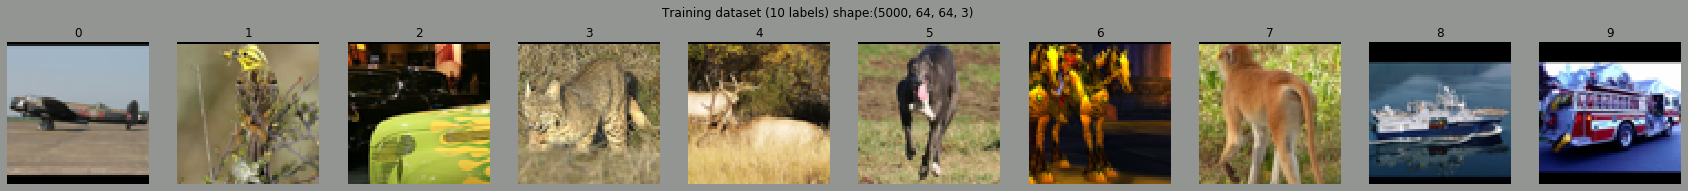

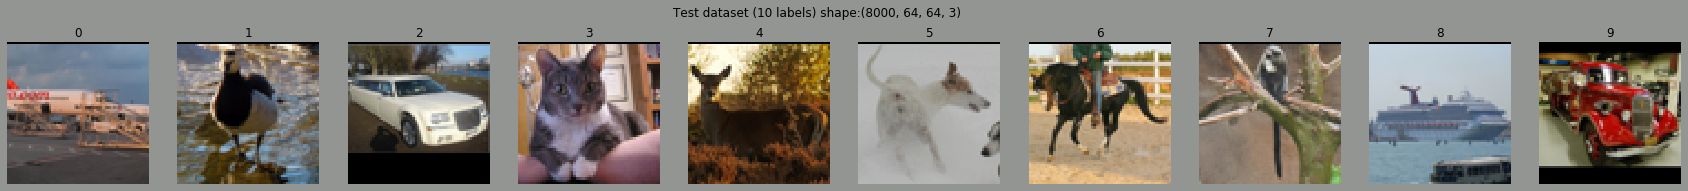

In [10]:
images = np.load('data/imgs_train.npy')
labels = np.load('data/labels_train.npy')

test_images = np.load('data/imgs_test.npy')
test_labels = np.load('data/labels_test.npy')

images[..., 0, :, :] = 0
test_images[..., 0, :, :] = 0

plot_image('Training dataset (10 labels) shape:', images, labels)
plot_image('Test dataset (10 labels) shape:', test_images, test_labels)

train_images, train_labels, val_images, val_labels = split_data(images, labels)
train_dataset, train_dataloader, val_dataset, val_dataloader, test_dataset, test_dataloader = prepare_dataset(train_images, train_labels, val_images, val_labels, test_images, test_labels)

In [11]:
result2_test_01_10 = train_linear(0.01,10)
result2_test_001_20 = train_linear(0.001,20)
result2_test_0001_30 = train_linear(0.0001,30)

Run with 0.01 learning rate and number of epochs: 10
Epoch 01/10: train_loss: 2.0510, train_accuracy: 028.8000, val_loss: 2.0902, val_accuracy: 31.2000
Epoch 02/10: train_loss: 1.8104, train_accuracy: 037.6444, val_loss: 1.9828, val_accuracy: 33.2000
Epoch 03/10: train_loss: 1.6676, train_accuracy: 041.1333, val_loss: 1.9192, val_accuracy: 34.2000
Epoch 04/10: train_loss: 1.5816, train_accuracy: 045.2667, val_loss: 2.1074, val_accuracy: 28.4000
Epoch 05/10: train_loss: 1.4915, train_accuracy: 047.8667, val_loss: 2.1315, val_accuracy: 30.6000
Epoch 06/10: train_loss: 1.4251, train_accuracy: 050.6889, val_loss: 2.1702, val_accuracy: 31.6000
Epoch 07/10: train_loss: 1.3393, train_accuracy: 054.6000, val_loss: 2.1579, val_accuracy: 30.6000
Epoch 08/10: train_loss: 1.2901, train_accuracy: 055.6444, val_loss: 1.9513, val_accuracy: 32.2000
Epoch 09/10: train_loss: 1.2555, train_accuracy: 057.9778, val_loss: 2.1331, val_accuracy: 31.8000
Epoch 10/10: train_loss: 1.2094, train_accuracy: 059.288

#### Report below
*Traning and validation loss and accuracy for different learning rates  
Learning rate of the best model  
Test loss and accuracy for the best model  
Compare training, val and test loss and accuracy with the previous model  
Visualize weights of the new model, comment on the differences*


Results from 0.01 learning rate and number of epochs: 10


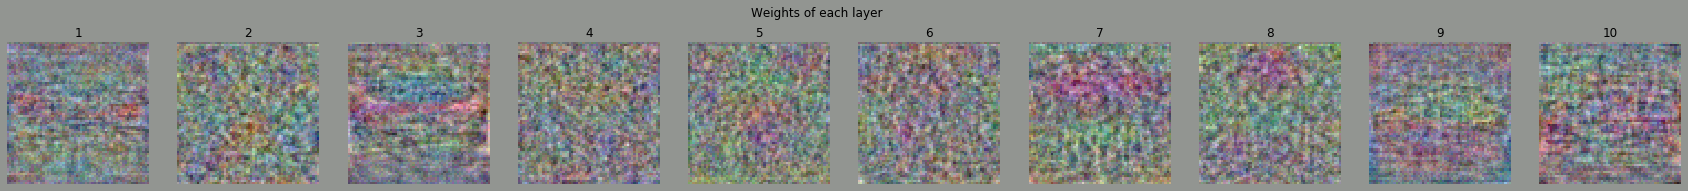

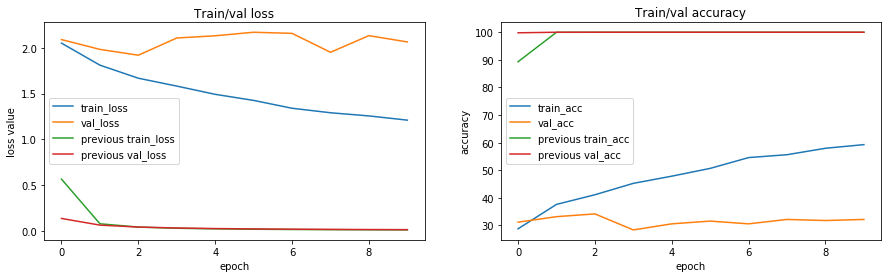

Mean loss 2.0553330574035646, Accuracy: 34.1375

Results from 0.001 learning rate and number of epochs: 20


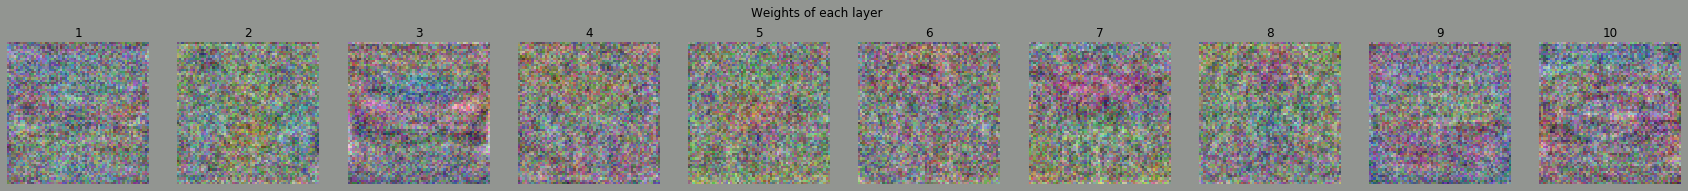

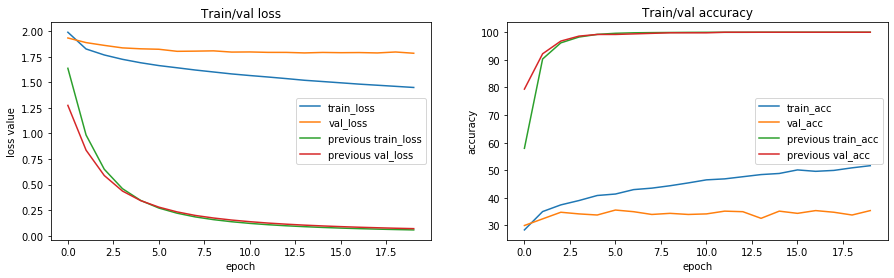

Mean loss 1.7599190449714661, Accuracy: 36.7375

Results from 0.0001 learning rate and number of epochs: 30


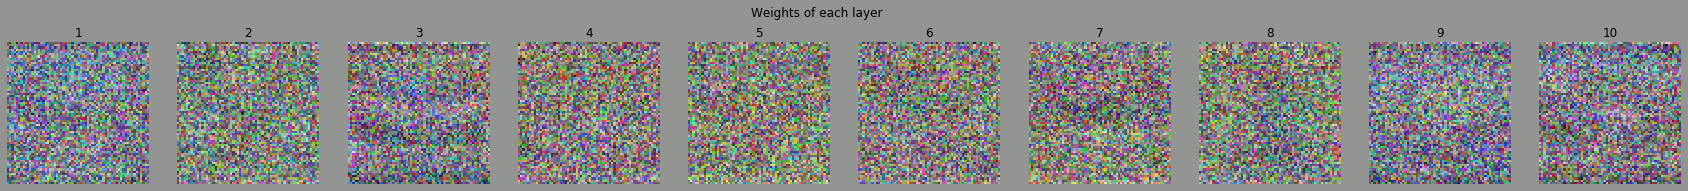

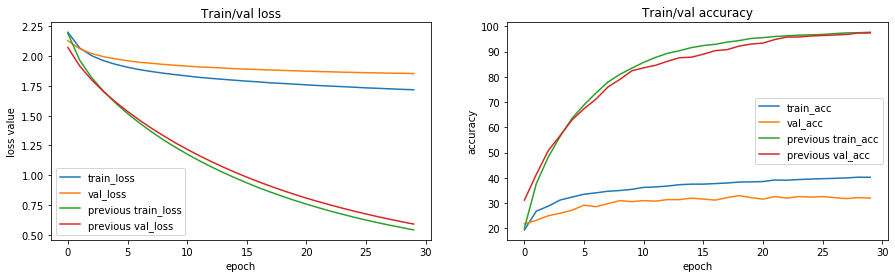

Mean loss 1.8033286957740784, Accuracy: 35.3



In [12]:
plot_results(result2_test_01_10, test_dataloader, previous_results=result_test_01_10)
plot_results(result2_test_001_20, test_dataloader, previous_results=result_test_001_20)
plot_results(result2_test_0001_30, test_dataloader, previous_results=result_test_0001_30)

**Answers**

We simply remove the code from the images. With setting the first row of each image to zero (black) the model does not consider this data anymore. The differences are enourmous. The model is not likely to overfit over few epoches as before and the weights are different, the distribution of the weights is better, one could even recognize the objects slightly.

The best results are achived with 0.001 learning rate and number of 20 epochs. The evaluation on the test set is:

**Mean loss 1.760011354446411, Accuracy: 37.375**